In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import imblearn
import sklearn as sk
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import f_classif, mutual_info_classif

In [81]:
import warnings
warnings.filterwarnings("ignore")

# Банковский скоринг
Скоринг, который позволяет спрогнозировать вероятность невозврата кредита, тем самым оптимизируя работу банка.

**Задача** выбрать и обучить модель предсказывать эту вероятность для новых наблюдений. В процессе подобрать лучшую комбинацию признаков и гиперпараметров, чтобы максимизировать рзультат по метрике AUC-ROC.

# Useful functions

In [82]:
def get_boxplot(column):
    
    # plot boxplots for numerical features
    
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x='default', y=column,
                data=data,
                ax=ax, showmeans=True)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    
def vis_importance(xcol, ycol):
    
    # plot histograms for categorical features to visualize
    # dependence on target variable
    # xcol - feature to explore, ycol - target variable
    
    pd.crosstab(data[xcol], data[ycol]).plot(kind='bar')
    plt.title('Default frequency for {}'.format(xcol))
    plt.xlabel(xcol)
    plt.ylabel('Frequency of default')
    plt.show()
    
def outliers_detection(data, col):
    
    # detect outliers in data[col]
    
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    IQR = perc75 - perc25
    left = perc25 - 1.5 * IQR
    right = perc75 + 1.5 * IQR
    print(col+' feature')
    print('min: {0}, max: {1}'.format(data[col].min(), data[col].max()))
    print('outlier boundaries: [{0}, {1}]'.format(left, right))
    if len(data[~data[col].between(left, right)]) > 0:
        print('ratio of outliers: {}'.format(len(data[(~data[col].between(left, right))&(~data[col].isna())])/len(data)))

def drop_outliers(data, col):
    
    # detect outliers in data[col]
    
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    IQR = perc75 - perc25
    return data[(data[col].between(perc25 - 1.5 * IQR, perc75 + 1.5 * IQR))|(data[col].isna())]

# Data loading

In [83]:
data = pd.read_csv('train_kaggle.csv')
test = pd.read_csv('test_kaggle.csv')

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

## Description
client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы


bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

# EDA & Data Preprocessing

In [85]:
# columns by types, some columns will be added soon
num_col = ['days_passed', 'age', 'decline_app_cnt', 'score_bki',
          'region_rating', 'income']
cat_col = ['app_date_month', 'education', 'home_address', 'work_address', 'sna',
          'first_time']
bin_col = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [86]:
# convert to datetime
data.app_date = pd.to_datetime(data.app_date)
test.app_date = pd.to_datetime(test.app_date)

## Education feature

ration of nan: 0.004159947966774618


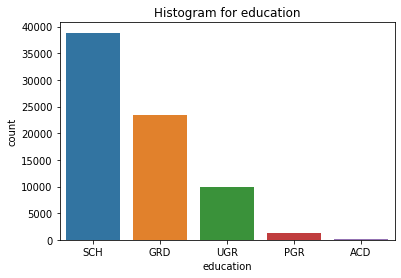

In [87]:
sns.countplot(data['education'])
plt.title('Histogram for education')
print('ration of nan: {}'.format(data.education.isna().sum()/len(data)))

Пропуски можно заполнить наиболее популярным классом, но доля пропущенных значений (хоть она и очень мала) больше, чем доля одного из классов ('ACD'). Поэтому выделяю отдельную категорию 'not defined' для пропусков.

In [88]:
data.education.fillna('not defined', inplace=True)

## App_date feature
Переменная типа 'datetime', всего порядка 120 уникальных значений. Перевод всех значений без сокращений в тип dummy никак не улучшил качество модели, поэтому достану пару новых признаков: сколько прошло дней и месяц подачи заявки.

In [89]:
# feature engeneering
today = pd.to_datetime('27JULY2020')
data['days_passed'] = (today - data.app_date).dt.days
data['app_date_month'] = data['app_date'].dt.month

test['days_passed'] = (today - test.app_date).dt.days
test['app_date_month'] = test['app_date'].dt.month

## Outliers

In [90]:
# detect & drop ouliers in score_bki
outliers_detection(data=data, col='score_bki')
#data = drop_outliers('score_bki')

score_bki feature
min: -3.62458632, max: 0.19977285
outlier boundaries: [-3.2940876975, -0.5352773974999998]
ratio of outliers: 0.0047561620076152795


In [91]:
# detect & drop ouliers in bki_request_cnt
outliers_detection(data, 'bki_request_cnt')
#data = drop_outliers('bki_request_cnt')

bki_request_cnt feature
min: 0, max: 53
outlier boundaries: [-4.5, 7.5]
ratio of outliers: 0.023780810038076396


In [92]:
# detect & drop ouliers in income
outliers_detection(data, 'income')
#data = drop_outliers('income')

income feature
min: 1000, max: 1000000
outlier boundaries: [-22000.0, 90000.0]
ratio of outliers: 0.06361874822152061


Квартильный метод обнаруживает ощутимое количество выбросов (около 9%). Обучение лог регрессии на данных, полностью или частично очищенных от выбросов, ухудшало результат по метрике. Вероятно это связано с тем, что тестовая выборка содержит выбросы, избавится от которых нельзя, поэтому модель, которая уже "видела" экстремальные значения на обучении, при тестировании работает качественнее.

## Default - target variable

Text(0.5, 1.0, 'Histogram for default')

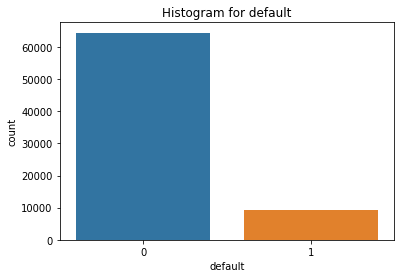

In [93]:
sns.countplot(data.default)
plt.title('Histogram for default')

Выборка является несбалансированной: "дефолтные" клиенты составляют всего около 12%. Я попробовала поизменять данные методами over-\undersampling, также использовала алгоритм SMOTE, вот [здесь](https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/) хорошо об этом написано. Однако это никак не улучшило результат модели, поэтому оставляю выборку несбалансированной.

## Distribution of numerical features

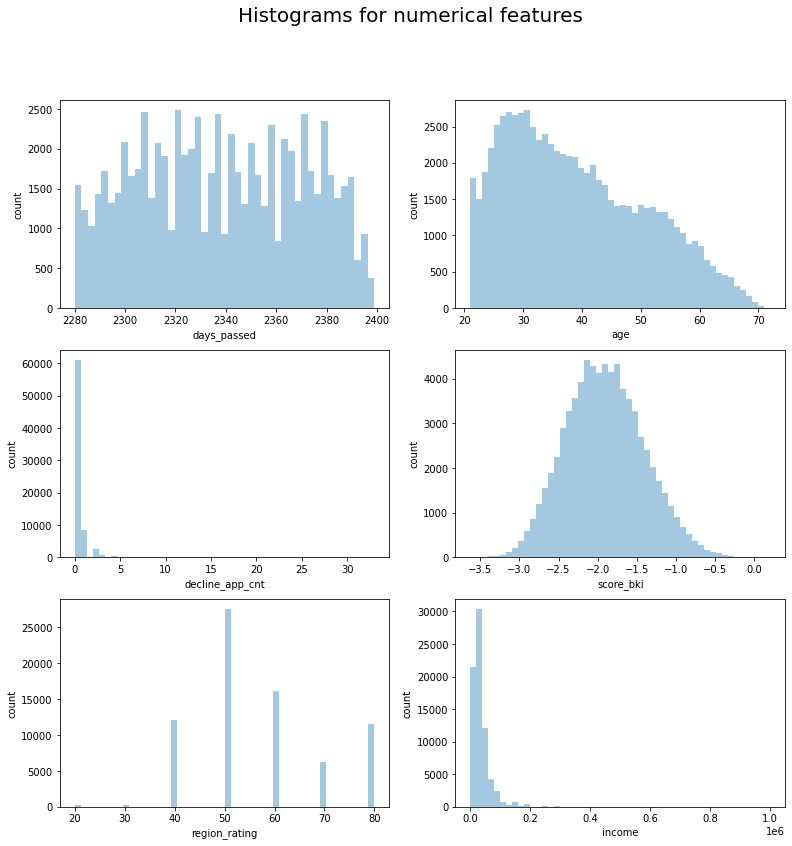

In [94]:
fig, axes = plt.subplots(3, 2, figsize=(13,13))
for col, i in zip(num_col, range(6)):
    sns.distplot(data[col], kde=False, ax=axes.flat[i])
    axes.flat[i].set(ylabel='count')

fig.suptitle('Histograms for numerical features', fontsize=20);

С помощью логарифмирования приведу распределение признаков 'age' и 'income' к более "нормальному" виду.

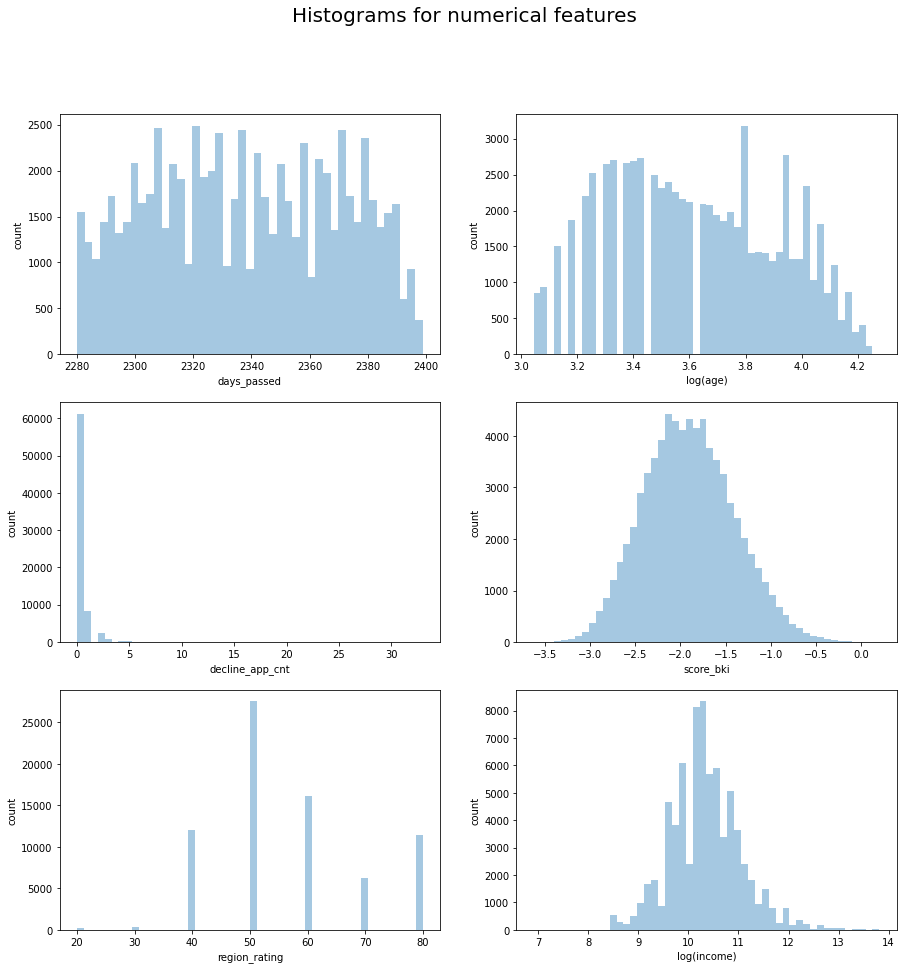

In [95]:
# normalization using log func
col_to_log = ['age', 'income']
fig, axes = plt.subplots(3, 2, figsize=(15,15))
for col, i in zip(num_col, range(6)):
    if col in col_to_log:
        sns.distplot(data[col][data[col]>0].apply(lambda w: np.log(w)),
                     kde=False, ax=axes.flat[i])
        axes.flat[i].set(xlabel='log({})'.format(col))
    else: sns.distplot(data[col], kde=False, ax=axes.flat[i])
    axes.flat[i].set(ylabel='count')

fig.suptitle('Histograms for numerical features', fontsize=20);

In [96]:
data[col_to_log] = data[col_to_log].apply(lambda w: np.log(w))
test[col_to_log] = test[col_to_log].apply(lambda w: np.log(w))

## Features' significance

### Visual assessment of categorical variables

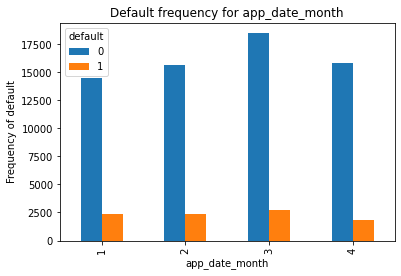

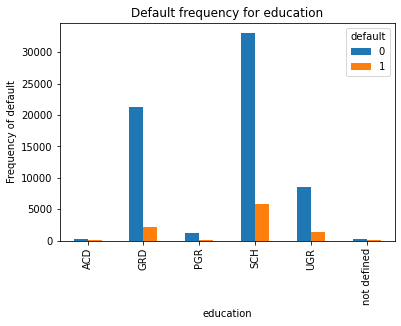

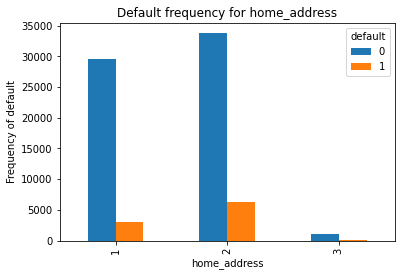

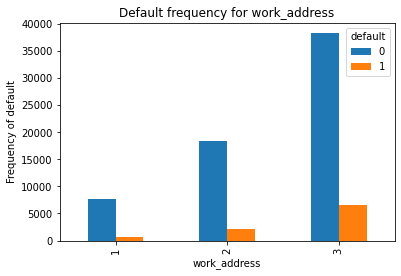

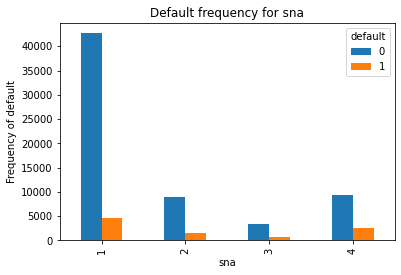

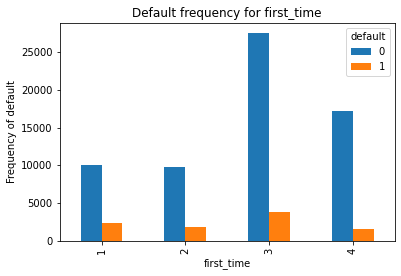

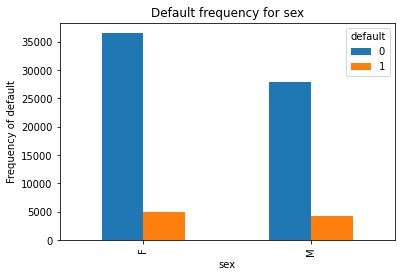

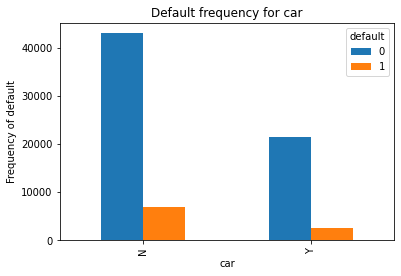

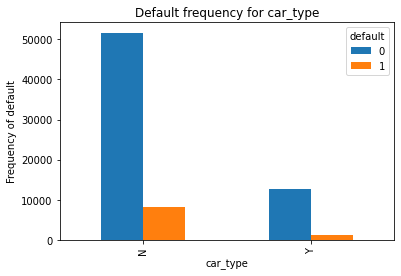

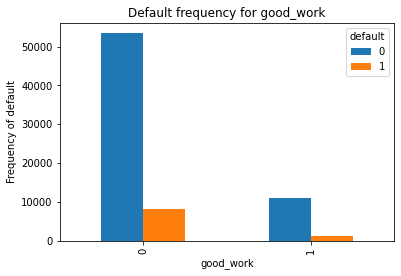

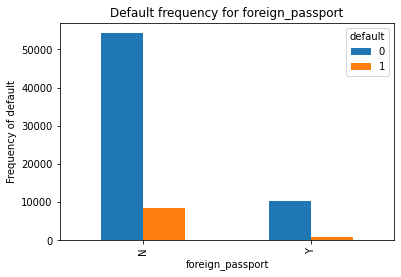

In [97]:
for col in cat_col + bin_col:
    vis_importance(col, 'default')

По визуальному наблюдению все категориальные признаки могут иметь значимость для предсказания дефолта. Разве что признак 'sex' кажется слабым предиктором. Хотя среди женщин ~ на 10к больше нулей дефолта, нужно учитывать, что в датасете женщин в целом примерно ~ на 10к больше, чем мужчин.

### Visual assessment of numerical variables

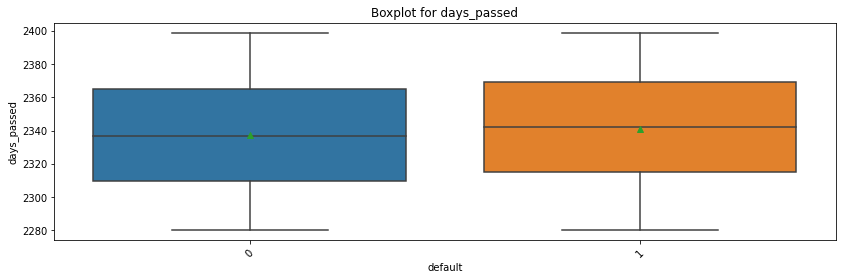

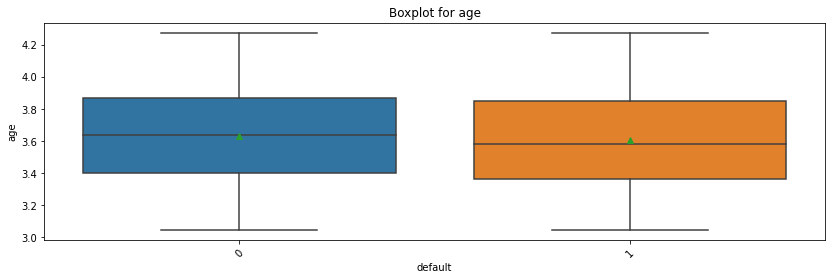

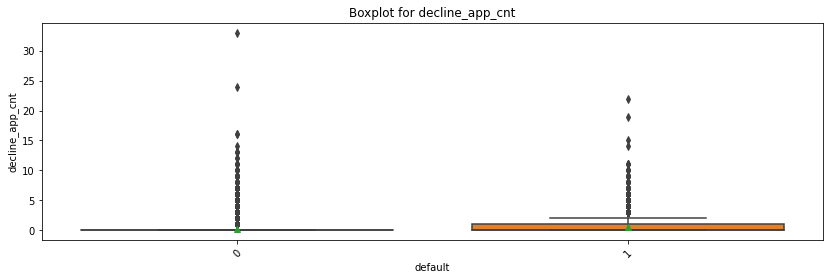

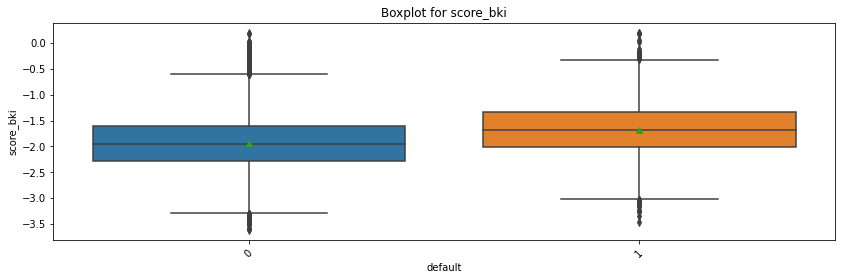

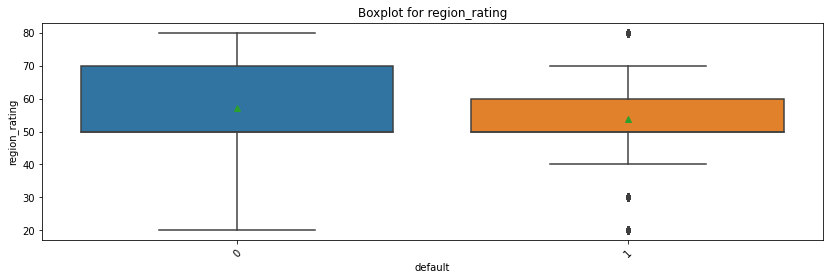

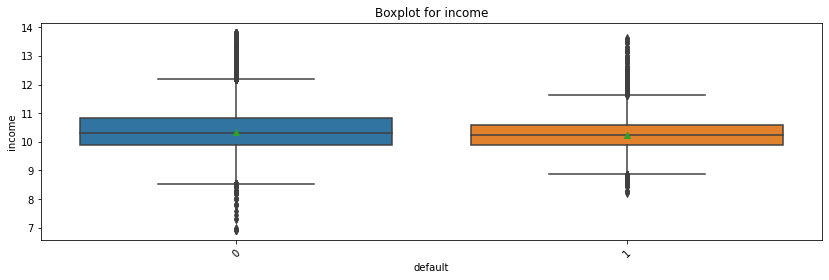

In [98]:
for col in num_col:
    get_boxplot(col)

Наблюдения: у дефолтных клиентов среднее и медиана в признаках 'days_passed', 'score_bki' выше, чем у недефолтных. Наоборот, среднее и медиана ниже, в признаках 'age', 'region_rating'. Заметны различия в разбросе значений у дефолтных и недефолтных клиентов в признаках 'decline_app_cnt', 'score_bki'.

### Statistical assessment of categorical variables

In [99]:
# encoding categorical cols
for col in ['education', 'sex', 'car', 'car_type', 'foreign_passport']:
    encoded_vals, _ = pd.factorize(data[col])
    data[col] = encoded_vals
    
for col in ['education', 'sex', 'car', 'car_type', 'foreign_passport']:
    encoded_vals, _ = pd.factorize(test[col])
    test[col] = encoded_vals

<AxesSubplot:>

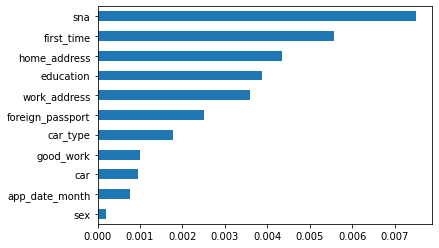

In [100]:
# check importance of categorical variables
imp_cat = pd.Series(mutual_info_classif(data[bin_col + cat_col],
                                        data['default'], discrete_features =True),
                    index = bin_col + cat_col)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Догадка о малой значимости признака 'sex' подтвердилась + теперь видно, что примерно ту же значимость имеет признак 'car' - флаг наличия машины.

### Statistical assessment of numerical variables

Text(0.5, 0, 'F-value')

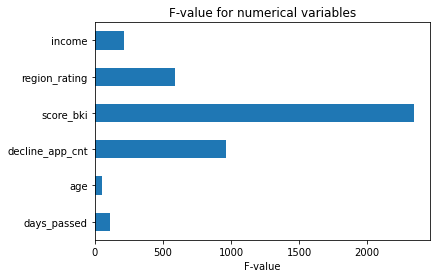

In [101]:
# check importance of numerical variables
imp_num = pd.Series(f_classif(data[num_col],
                              data['default'])[0], index=num_col)
imp_num.plot(kind='barh')
plt.title('F-value for numerical variables')
plt.xlabel('F-value')

## Correlation matrix

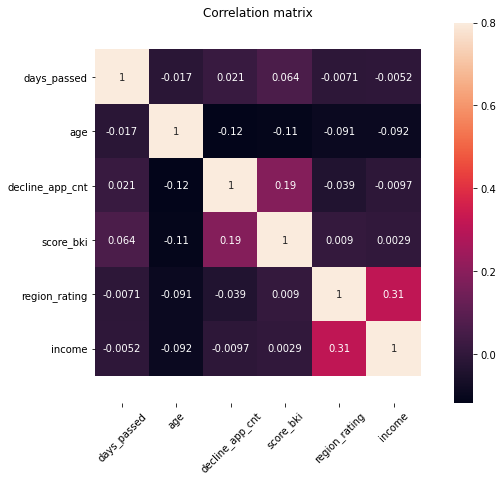

In [102]:
corrmat = data[num_col].corr()
f, ax = plt.subplots(figsize=(12, 7))
chart = sns.heatmap(corrmat, vmax=.8, square=True, annot=True)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
bottom, top = chart.get_ylim()
plt.title('Correlation matrix')
ax.set_ylim(bottom + 0.5, top - 0.5);

Признаки 'income' и 'region_rating' скоррелированы. Так как 'income' имеет меньшую значимость по статистической оценке, удаляю его.

In [103]:
data.drop('income', axis=1, inplace=True)
test.drop('income', axis=1, inplace=True)

In [104]:
num_col = ['days_passed', 'age', 'decline_app_cnt', 'score_bki',
          'region_rating']

# Data Preprocessing

In [105]:
# categorical variables -> dummy-variables
X_cat = sk.preprocessing.OneHotEncoder(sparse=
                        False).fit_transform(data[cat_col].values)

test_cat = sk.preprocessing.OneHotEncoder(sparse=
                        False).fit_transform(test[cat_col].values)

In [106]:
# polynomial feature engeneering
X_num = PolynomialFeatures(2).fit_transform(data[num_col].values)[:,1:]

test_num = PolynomialFeatures(2).fit_transform(test[num_col].values)[:,1:]

In [107]:
X_num = sk.preprocessing.StandardScaler().fit_transform(X_num)

test_num = sk.preprocessing.StandardScaler().fit_transform(test_num)

# Model fitting

In [108]:
X = np.hstack([X_num, X_cat, data[bin_col].values])
y = data['default']

client_id_test = test.client_id
test = np.hstack([test_num, test_cat, test[bin_col].values])

Методами GridsearchCV, проб и ошибок и иногда пальцем в небо тыканием, остановилась на логистической регрессии с дефолтным решателем и подобранным параметром регуляризации.

In [109]:
log_reg = sk.linear_model.LogisticRegression(C=59.95, solver='lbfgs', max_iter=500)
model_log_reg = log_reg.fit(X, y)
y_pred_probs = model_log_reg.predict_proba(test)

# Validation

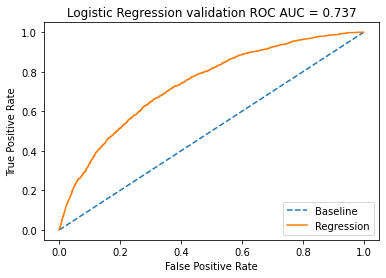

In [110]:
X_train, X_valid, y_train, y_valid = sk.model_selection.train_test_split(X, y, test_size=0.20, random_state=33)
model_log_reg_valid = log_reg.fit(X_train, y_train) # "retrain" same model on X_train (X_train.shape[0]<X.shape[0])
probs = model_log_reg.predict_proba(X_valid)[:,1]

fpr, tpr, threshold = sk.metrics.roc_curve(y_valid, probs)
roc_auc = sk.metrics.roc_auc_score(y_valid, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression validation ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Testing & Results
Делаю сабмит на kaggle, ссылка на соревнование [тут](https://www.kaggle.com/c/sf-dst-scoring).

In [111]:
my_submission = pd.DataFrame({'client_id': client_id_test, 
                              'default': y_pred_probs[:, 1]})
my_submission.to_csv('submission.csv', index=False)

In [114]:
my_submission

,client_id,default
0,74835,0.035773
1,17527,0.344031
2,75683,0.049025
3,26883,0.072745
4,28862,0.033713
...,...,...
36344,83775,0.317310
36345,106254,0.011881
36346,81852,0.383310
36347,1971,0.112827


Результат тестирования модели по метрике AUC ROC: 0.73154

Leaderboard на kaggle по [ссылке](https://www.kaggle.com/c/sf-dst-scoring/leaderboard).